# Feed forward neural network example using mxnet

Tue 11 Apr 2017 12:24:25 EDT


The steps below are **heavily** inspired by these tutorials:
  - https://github.com/dmlc/mxnet-gtc-tutorial/blob/master/tutorial.ipynb
  - https://github.com/dmlc/mxnet/blob/master/example/svm_mnist/svm_mnist.py



In [1]:
import numpy as np
import mxnet as mx
from sklearn.decomposition import PCA

# for in-notebook graphics
%matplotlib inline
import matplotlib.pyplot as plt

import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


## STEP 1: Fetch MNIST dataset

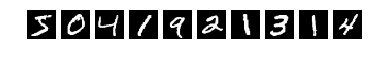

label: [5 0 4 1 9 2 1 3 1 4]


In [2]:
import os
from urllib.request import urlretrieve
import gzip
import struct

def download_data(url, force_download=False):
    if not os.path.exists('data'):
        os.mkdir('data')
    fname = url.split("/")[-1]
    data_file = os.path.join('data', fname)
    if force_download or not os.path.exists(data_file):
        urlretrieve(url, data_file)
    return data_file

def read_data(label_url, image_url):
    with gzip.open(download_data(label_url)) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(download_data(image_url), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

path='http://yann.lecun.com/exdb/mnist/'
(train_lbl, train_img) = read_data(
    path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(test_lbl, test_img) = read_data(
    path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')


# check we have digits
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print('label: %s' % (train_lbl[0:10],))

In [3]:
# For training, we want data as floats
def int_img_to_float(img_array):
    return img_array.astype(np.float32)/255

# For training, we want data as floats
def float_img_to_int(img_array):
    return (img_array.reshape((28,28))*255).astype(np.uint8)

train_img = int_img_to_float(train_img)
test_img = int_img_to_float(test_img)

In [4]:
# info about training data
print( "number training images:", len(train_img), len(train_lbl) )
print( "each image shape:", train_img[0].shape )

# info about training data
print( "number training images:", len(test_img), len(test_lbl) )

# sample image data
train_img[0].shape

number training images: 60000 60000
each image shape: (28, 28)
number training images: 10000 10000


(28, 28)

## STEP 2: build NN

In [5]:
data = mx.symbol.Variable('data')

# The input is fed to a fully connected layer that computes Y=WX+b.
# This is the main computation module in the network.
# Each layer also needs an unique name. We'll talk more about naming in the next section.
fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=128)
# Activation layers apply a non-linear function on the previous layer's output.
# Here we use Rectified Linear Unit (ReLU) that computes Y = max(X, 0).
act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")

fc2  = mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 64)
act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")

fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=10)
# Finally we have a loss layer that compares the network's output with label and generates gradient signals.
mlp  = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')


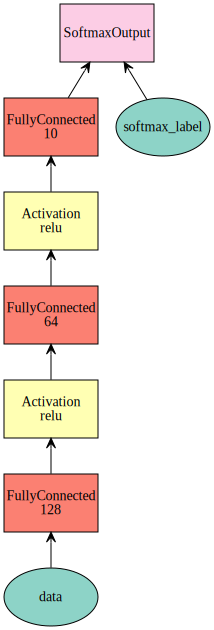

In [6]:
# show me
mx.viz.plot_network(mlp)

In [7]:
# show args and params
mlp.list_arguments()

['data',
 'fc1_weight',
 'fc1_bias',
 'fc2_weight',
 'fc2_bias',
 'fc3_weight',
 'fc3_bias',
 'softmax_label']

In [8]:
# setup training
batch_size = 200
train_iter = mx.io.NDArrayIter(train_img, train_lbl, batch_size=batch_size)
test_iter = mx.io.NDArrayIter(test_img, test_lbl, batch_size=batch_size)



In [9]:
# do the training
model = mx.model.FeedForward(
    ctx = mx.cpu(0), # Run on CPU 0
    # ctx = mx.gpu(0),      # Run on GPU 0
    symbol = mlp,         # Use the network we just defined
    num_epoch = 10,       # Train for 10 epochs
    learning_rate = 0.1,  # Learning rate
    momentum = 0.9,       # Momentum for SGD with momentum
    wd = 0.00001)         # Weight decay for regularization

model.fit(
    X=train_iter,  # Training data set
    eval_data=test_iter,  # Testing data set. MXNet computes scores on test set every epoch
    batch_end_callback = mx.callback.Speedometer(batch_size, 200))  # Logging module to print out progress

INFO:root:Start training with [cpu(0)]


[Deprecation Warning] mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


INFO:root:Epoch[0] Batch [200]	Speed: 71087.10 samples/sec	Train-accuracy=0.400225
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.849
INFO:root:Epoch[0] Validation-accuracy=0.925000
INFO:root:Epoch[1] Batch [200]	Speed: 69085.94 samples/sec	Train-accuracy=0.936375
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.928
INFO:root:Epoch[1] Validation-accuracy=0.951200
INFO:root:Epoch[2] Batch [200]	Speed: 68241.56 samples/sec	Train-accuracy=0.962525
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.883
INFO:root:Epoch[2] Validation-accuracy=0.964800
INFO:root:Epoch[3] Batch [200]	Speed: 71524.99 samples/sec	Train-accuracy=0.973975
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.839
INFO:root:Epoch[3] Validation-accuracy=0.967500
INFO:root:Epoch[4] Batch [200]	Speed: 73476.32 samples/sec	Train-accuracy=0.978900
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.822
INF

## STEP 3: Evaluate model results

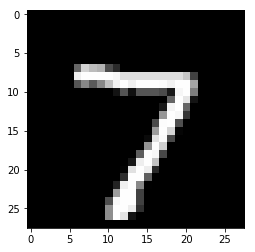

Result: 7


In [10]:
plt.imshow(test_img[0], cmap='Greys_r')
plt.show()
print('Result:', model.predict(test_img[0:1])[0].argmax() )

In [11]:
print('Accuracy:', model.score(test_iter)*100, '%')

Accuracy: 96.96 %


## Cleanup data files

In [12]:
for filename in ['t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz']:
    data_file = os.path.join('data', filename)
    os.remove(data_file)